# Assignment 1 Wei Chen 001562214

## 1.Bandit Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

## 2.Algorithms

### 2.1 Thompson Sampling

In [2]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

### 2.2 E-greedy

In [3]:
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit,epsilon = 0.1):
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

### 2.3 UBC

In [4]:
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit,ucb_c = 2):
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### 2.4  Random Sampling

In [5]:
# author: Wei Chen

class RandomSampling():
  """
  Random Sampling
  """
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
  
  @staticmethod
  def name():
    return 'random-sampling'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret

  def _update_params(self, arm, reward):
    return

## 3.Helper Function

### 3.1 Normal simulate and experiment
The function simulate will simulate the learning for a single algorithm and return the mean regrets over a number of trials. The experiment function runs the simulations over all algorithms and plots their mean regrets

In [6]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson,RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

### 3.2 Fixed simulate and experiment
The function single_simulate will simulate the learning for a single algorithm and return the mean regrets over a number of trials. The single_experiment function runs the simulations over one algorithm and plots mean regrets

In [7]:
def plot_data_solo(data,paras):
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=paras[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  # plt.rcParams["figure.figsize"] = (12,8)
  plt.show()

def single_simulate(name,simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit,name)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def single_experiment(names,algo,arm_count=10,timesteps=1000, simulations=1000):
  
  algos = {EpsilonGreedy:epsilons, UCB:ucb_c}

  regrets = []
  for i in names:
    algos[algo]=i
    regrets.append(single_simulate(algos[algo],simulations, timesteps, arm_count, algo))

  plot_data_solo(regrets,names)

# Optimize your Bandit Problem using Thompson Sampling, e-greedy, UBC, and random sampling.

# Answer the following questions 

## Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

*    Thompson Sampling: Thompson Sampling does not have any hyperparameter.
*    E-greedy: eplison is the important hyperparameter.
*    UBC: ucb_c is the important hyperparameter.
*    Random Sampling:Random Sampling does not have any hyperparameter.

From Experiment 1, we can see that when epsilon increases, the cost of converging is much more quickly,but has worse performance.

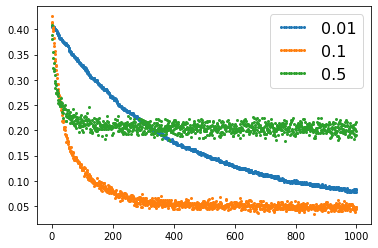

In [8]:
# Experiment 1
epsilons = [0.01,0.1,0.5]
ucb_c = 2
stationary=True
single_experiment(epsilons,EpsilonGreedy)

From Experiment 2, we can see that when ucb_c increases, it converges much more slowly and it increased the "premium" the agent adds to uncertainty.

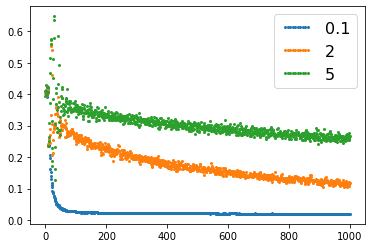

In [9]:
# Experiment 2
epsilon = 0.1
ucb_cs = [0.1,2,5]
stationary=True
single_experiment(ucb_cs,UCB)

## How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

From Experiment 3, we increase the action space from 3 to 50, we set other parameters same and change arm count only, we can see that when the action space increases, except ramdom sampling, other sampling will cost much more time to converge. The E-greedy agent budges in its learning pattern when compared to the smallest. UCB is drastically unstable and diverges.The Thompson agent slowly decreases regret to eventually outperform E-greedy around step 180.

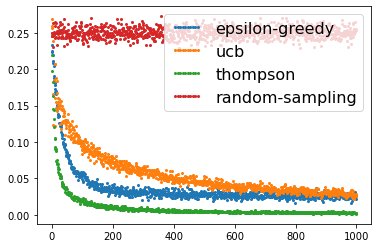

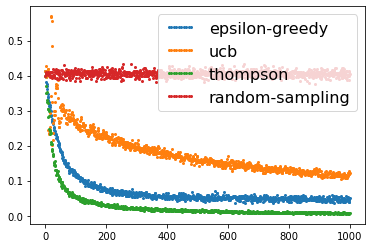

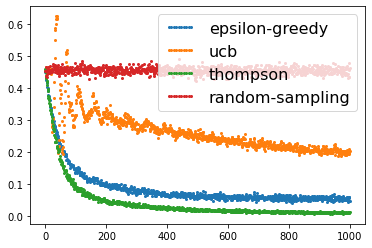

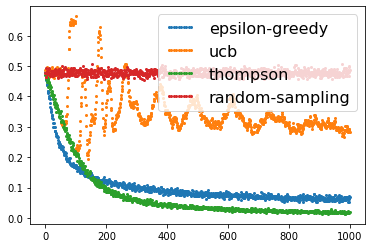

In [10]:
# Experiment 3
arm_count = [3,10,20,50] 
epsilon = 0.1
ucb_c = 2
stationary=True
for i in arm_count:
    experiment(i)

## How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

*    Thompson Sampling: After every 100 steps, the bandit resamples the action Bernouilli parameters,Thompson's regret quickly decreased, on average increase over time.
*    E-greedy: E-greedy's regret also quickly decreased and it hardly find the optimal every time.
*    UCB: Non-stationarity has special emphasis on exploration. So UCB reacts much more quickly and actually continues to improve in regret over time.
*    Random Sampling: As a control group, Random Sampling has stable performance.

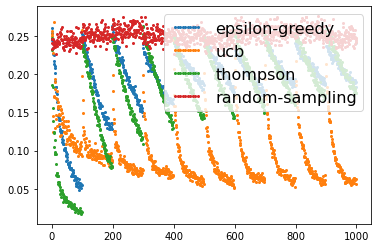

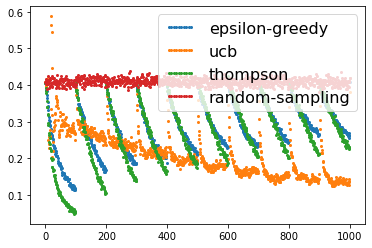

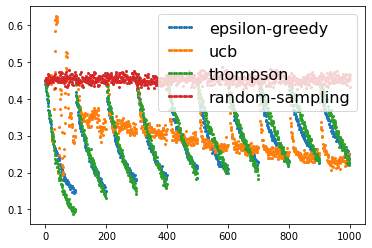

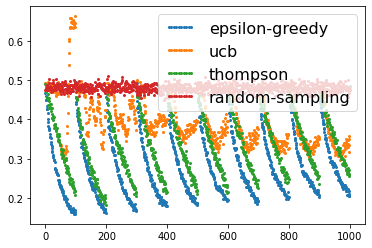

In [11]:
# Experiment 4
arm_count = [3,10,20,50] 
epsilon = 0.1
ucb_c = 2
stationary=False
for i in arm_count:
    experiment(i)

## When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

*    Thompson Sampling, E-greedy, UCB, and Random Sampling will not stop exploring till the simulation is done, which means they will infinitely close to 0 but never reach it.
*    exploration-exploitation tradeoff: Exploration and exploitation are two possible behaviours when facing a decision making problem.Exploitation consists of taking the decision assumed to be optimal with respect to the data observed so far. It tries to avoid bad decisions as much as possible but also prevents from discovering potential better decisions. On the other hand, exploration consists of not taking the decision that seems to be optimal, betting on the fact that observed data are not sufficient to truly identify the best option. This approach can sometimes lead to poor decisions but also makes it possible to discover better ones, if there exists any.As time goes, the reward is clear. Thus, samplings will more likely to choose bandits with high reward.

## How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points) 

*   Thompson Sampling: Thompson Sampling will always remember the past action, since it uses the result of each action to generate beta distributions and select the optimal with highest rewards.
*   E-greedy: E-greedy is the same as Thompson Sampling, it uses previous action to generate beta distribution and select the next optimal action with the highest rewards.
*   UCB: UCB will also remember the past action, since it select the next optimal action by calculating the uncertainty of actions.
*   Random Sampling: Random Sampling doesn't remember the past actions. It selects actions randomly using np.random.randint function.

## Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

In [12]:
import math
class ThompsonNormal():
  def __init__(self, bandit):
    """
      Normal distribution
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.mean = np.zeros(self.arm_count)
    self.std = np.zeros(self.arm_count)
    self.n = np.zeros(self.arm_count)
    
  def name():
    return 'thompson-normal'

  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.n[arm]+=1
    old_mean = self.mean[arm]
    new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
    self.mean[arm] = new_mean

    old_var = np.power(self.std[arm],2)
    if((self.n[arm]-1)!=0):
      new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    else:
      new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    self.std[arm] = math.sqrt(new_var)
    
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.mean, self.std)
    return theta.argmax()

In [13]:
def compare_two_thompson(arm_count, timesteps=1000, simulations=1000):
  
  algos = [BernThompson, ThompsonNormal]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

From Experiment 5, we can see that Beta distribution thompson is better than the Normal distribution thompson whether the arm count is small or large.

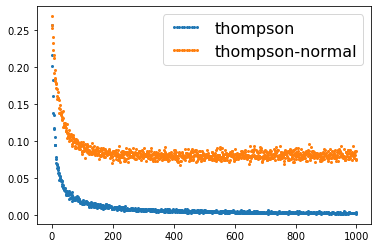

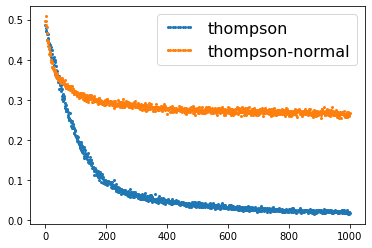

In [14]:
# Experiment 5
arm_count = [3,50] 
epsilon = 0.1
ucb_c = 2
stationary=True
for i in arm_count:
    compare_two_thompson(i)

## What code is yours and what have you adapted? (10 Points)

*   Random Sampling
*   Experiments
*   Single experiment helper function based on normal helper function

## Reference
[1]: Andre Cianflone-Thompson sampling. URL:https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb

[2]: Reinforcement Learning Guide: Solving the Multi-Armed Bandit Problem from Scratch in Python URL: https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/

[3]: Best Multi-Armed Bandit Strategy? (feat: UCB Method) URL:https://www.youtube.com/watch?v=FgmMK6RPU1c&t=654s

[4]: 强化学习指南：用Python解决Multi-Armed Bandit问题. URL:https://blog.csdn.net/weixin_41697507/article/details/89630828

[5]: Multi-Armed Bandit: epsilon-greedy URL: https://zhuanlan.zhihu.com/p/32335683